In [1]:
import pickle as pkl
import pandas as pd
import imodels

%load_ext autoreload
%autoreload 2

# this notebooks loads the performances for different models on various datasets into a pandas dataframe

In [2]:
model_comparison_path = '../tests/test_data/data/'
model_comparisons_file = model_comparison_path + 'model_comparisons.pkl'
df = pkl.load(open(model_comparisons_file, 'rb'))['df']

In [3]:
df[df.index.str.contains('Acc')]

,breast-cancer,breast-w,credit-g,haberman,heart,ionosphere,labor,vote
RandomForest (sklearn) Acc.,0.723593,0.964275,0.753,0.702909,0.822222,0.937344,0.893939,0.963218
GradientBoostingClassifier (sklearn) Acc.,0.720206,0.958561,0.760,0.686515,0.788889,0.923099,0.842424,0.954023
MLPClassifier (sklearn) Acc.,0.709800,0.952837,0.661,0.728715,0.822222,0.903421,0.674242,0.956322
SkopeRules Acc.,0.297459,0.655355,0.706,0.738340,0.444444,0.644225,0.718182,0.386207
RuleFit Acc.,0.695826,0.944224,0.722,0.663723,0.766667,0.923099,0.875758,0.944828
FPLasso Acc.,0.692438,0.957122,0.733,0.731676,0.825926,0.897586,0.859091,0.954023
FPSkope Acc.,0.591107,0.806937,0.695,0.734902,0.651852,0.684145,0.824242,0.657471
BRL Acc.,0.702541,0.944265,0.300,0.265098,0.629630,0.866117,0.663636,0.910345
GRL Acc.,0.370357,0.925663,0.700,0.705870,0.377778,0.358592,0.246970,0.043678
OneR Acc.,0.695765,0.905642,0.696,0.705870,0.700000,0.783380,0.784848,0.866667


# complexity-vs-accuracy plots for each model

In [4]:
import itertools
import os
from imodels.util.evaluate.compare_models import run_comparison
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt

COMPARISON_DATASETS = [
        ("breast-cancer", 13),
        ("breast-w", 15),
        ("credit-g", 31),
        ("haberman", 43),
        ("heart", 1574),
        ("labor", 4),
        ("vote", 56),
    ]

METRICS = [
    ('Acc.', accuracy_score),
    ('Time', None),
    ('Complexity', None)
    
]

def viz_model(result):
    
    complexities = result[result.index.str.contains('Complexity')]
    accuracies = result[result.index.str.contains('Acc')]
    complexity_sort_indices = complexities.argsort()
    
    plt.plot(complexities[complexity_sort_indices], accuracies[complexity_sort_indices])
    plt.xlabel('Complexity score')
    plt.ylabel('Average accuracy across comparison datasets')

def get_comparison_df(estimators):
    estimator_name = estimators[0][0]
    model_comparison_file = model_comparison_path + f'{estimator_name}_comparisons.pkl'
    if os.path.isfile(model_comparison_file):
        result = pkl.load(open(model_comparison_file, 'rb'))['df']
    else:
        result = run_comparison(COMPARISON_DATASETS, METRICS, estimators, write=False, average=True, verbose=False)
        pkl.dump({'df': result}, open(model_comparison_file, 'wb'))
    return result

## Random Forest

100%|██████████| 7/7 [00:01<00:00,  6.07it/s]


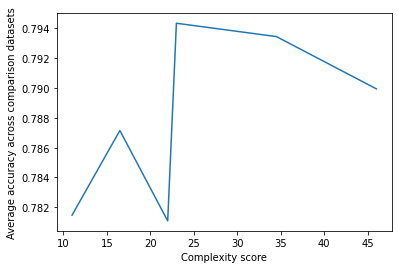

In [5]:
ESTIMATORS = [
    ('RandomForest (sklearn)', RandomForestClassifier(n_estimators=n, max_depth=d)) 
    for n, d in itertools.product([2, 3, 4], [2, 3])
]
result_rf = run_comparison(COMPARISON_DATASETS, METRICS, ESTIMATORS, write=False, average=True, verbose=False)
viz_model(result_rf)

## Gradient Boosted Trees

100%|██████████| 7/7 [00:00<00:00, 10.03it/s]


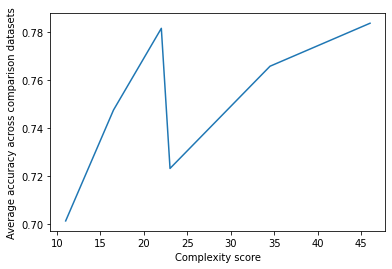

In [6]:
ESTIMATORS = [
    ('GradientBoostingClassifier (sklearn)', GradientBoostingClassifier(n_estimators=n, max_depth=d)) 
    for n, d in itertools.product([2, 3, 4], [2, 3])
]
result_gb = run_comparison(COMPARISON_DATASETS, METRICS, ESTIMATORS, write=False, average=True, verbose=False)
viz_model(result_gb)

## SkopeRules

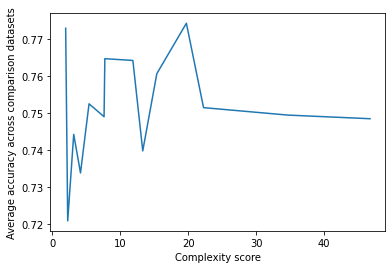

In [7]:
estimators = [
        ('skope', imodels.SkopeRulesClassifier(n_estimators=n, max_depth=d)) 
        for n, d in itertools.product([2, 4, 8, 16, 32, 64, 96], [2, 3])
    ]
result_sk = get_comparison_df(estimators)
viz_model(result_sk)

## RuleFit

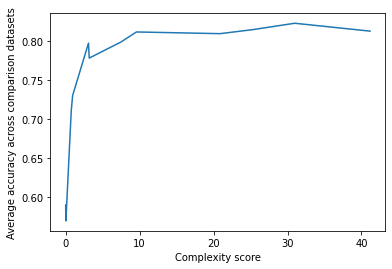

In [8]:
estimators = [
    ('rulefit', imodels.RuleFitClassifier(max_rules=n, tree_size=d)) 
    for n, d in itertools.product([2, 4, 8, 16, 32, 48], [4, 8])
]
result_ruf = get_comparison_df(estimators)
viz_model(result_ruf)

## FPLasso

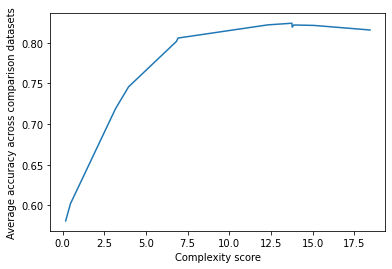

In [9]:
estimators = [
    ('fplasso', imodels.FPLassoClassifier(max_rules=n, maxcardinality=c)) 
    for n, c in itertools.product([2, 4, 8, 16, 32, 48, 96], [2, 3])
]
result_fpl = get_comparison_df(estimators)
viz_model(result_fpl)

## FPSkope

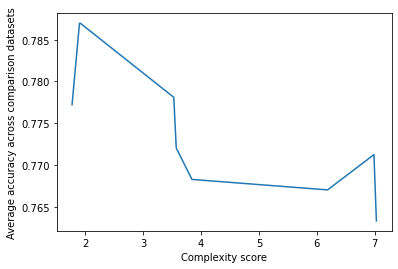

In [10]:
estimators = [
    ('fpskope', imodels.FPSkopeClassifier(maxcardinality=c,  max_depth_duplication=dd))
    for c, dd in itertools.product([2, 3, 4], [1, 2, 3])
]
result_fps = get_comparison_df(estimators)
viz_model(result_fps)

## Bayesian Rule List

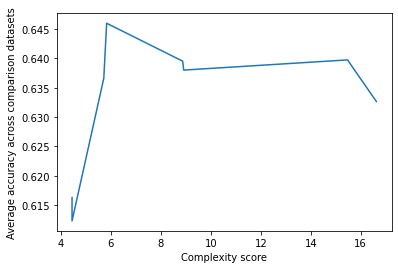

In [11]:
estimators = [
    ('brl', imodels.BayesianRuleListClassifier(listlengthprior=l, maxcardinality=c)) 
    for l, c in itertools.product([2, 4, 8, 16], [2, 3])
]
result_brl = get_comparison_df(estimators)
viz_model(result_brl)

## Greedy Rule List

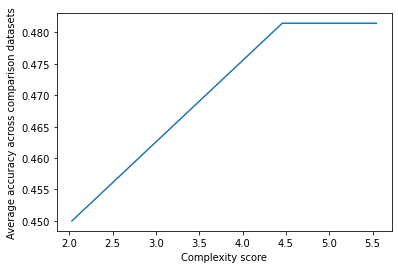

In [12]:
estimators = [('grl', imodels.GreedyRuleListClassifier(max_depth=d)) for d in [2, 4, 8, 16]]
result_grl = get_comparison_df(estimators)
viz_model(result_grl)

## OneR

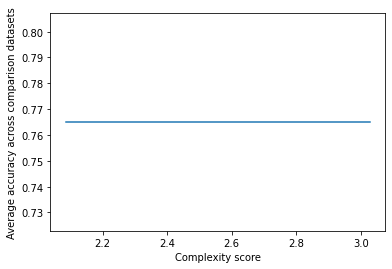

In [13]:
estimators = [('oner', imodels.OneRClassifier(max_depth=d)) for d in [2, 3, 4, 5, 6, 7]]
result_oner = get_comparison_df(estimators)
viz_model(result_oner)

## Boosted Rule Set

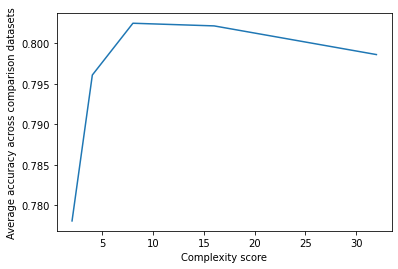

In [14]:
estimators = [('brs', imodels.BoostedRulesClassifier(n_estimators=n)) for n in [2, 4, 8, 16, 32]]
result_brs = get_comparison_df(estimators)
viz_model(result_brs)